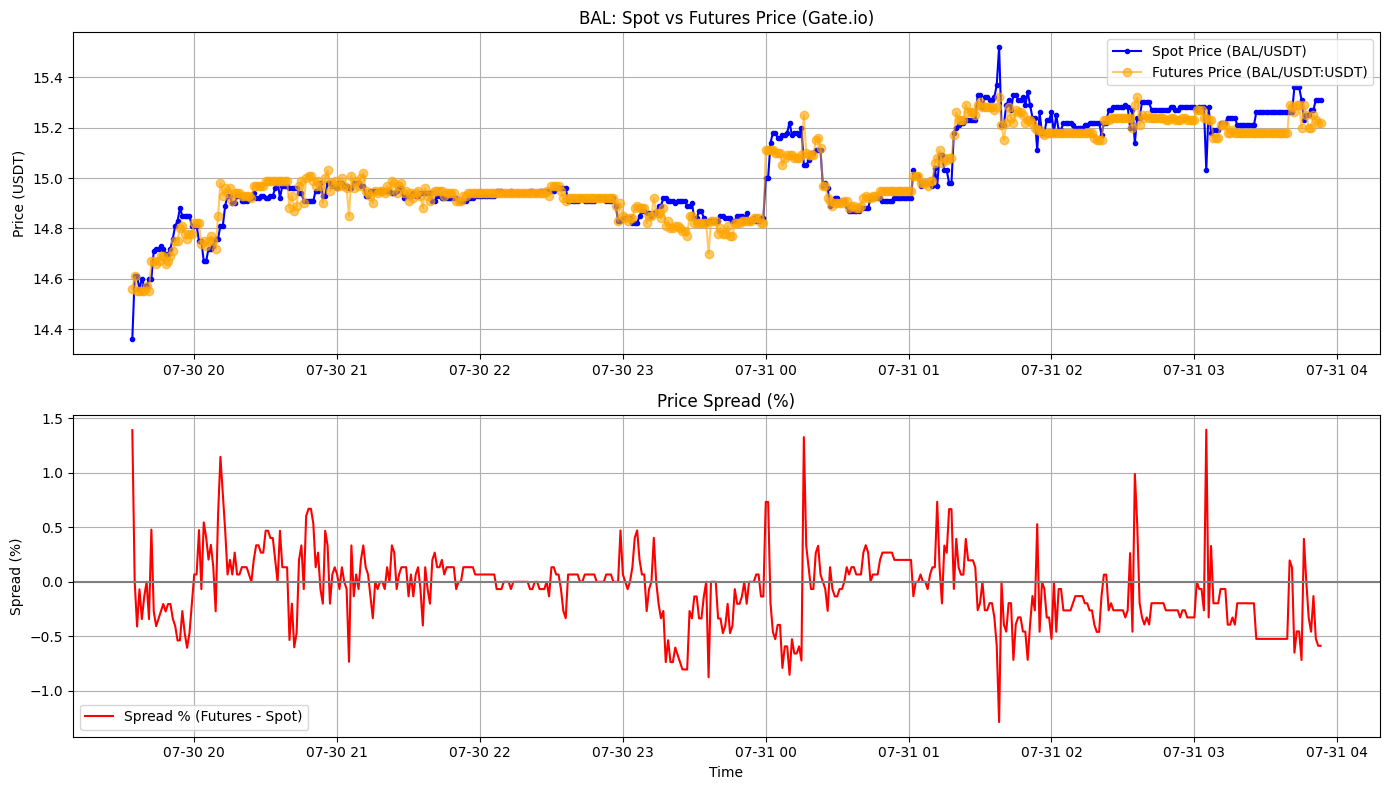

In [29]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt

# 设置交易对
# symbol_spot = 'BAL/USDT'            # 现货交易对
# symbol_future = 'BAL/USDT:USDT'     # 永续合约交易对

# # 初始化 Gate.io 实例
# spot = ccxt.gateio()
# future = ccxt.gateio({
#     'options': {
#         'defaultType': 'future'
#     }
# })



symbol_spot = 'BMEX/USDT'            # 现货
symbol_future = 'BMEX/USDT:USDT'     # 永续合约（USDT本位）

# bitmex     | BMEX/USDT:USDT
# spot = ccxt.bitmex()
# future = ccxt.bitmex({
#     'options': {
#         'defaultType': 'future'
#     }
# })

# gateio     | DFDVX/USDT:USDT

symbol_spot = 'DFDVX/USDT'            # 现货
symbol_future = 'DFDVX/USDT:USDT'     # 永续合约（USDT本位）
spot = ccxt.gateio()
future = ccxt.gateio({
    'options': {
        'defaultType': 'future'
    }
})

# 加载市场信息
spot.load_markets()
future.load_markets()

# 校验交易对是否存在
if symbol_spot not in spot.markets:
    raise Exception("现货交易对不存在：", symbol_spot)
if symbol_future not in future.markets:
    raise Exception("合约交易对不存在：", symbol_future)

# 获取 1 分钟 K 线数据（最近 100 条）
ohlcv_spot = spot.fetch_ohlcv(symbol_spot, timeframe='1m', limit=500)
ohlcv_fut = future.fetch_ohlcv(symbol_future, timeframe='1m', limit=500)

# 转换为 DataFrame 格式
df_spot = pd.DataFrame(ohlcv_spot, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df_fut = pd.DataFrame(ohlcv_fut, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# 转换时间戳为时间
df_spot['datetime'] = pd.to_datetime(df_spot['timestamp'], unit='ms')
df_fut['datetime'] = pd.to_datetime(df_fut['timestamp'], unit='ms')

# 设置 datetime 为索引
df_spot.set_index('datetime', inplace=True)
df_fut.set_index('datetime', inplace=True)

# 只保留收盘价，并对齐时间索引
df = pd.DataFrame()
df['spot'] = df_spot['close']
df['future'] = df_fut['close']
df.dropna(inplace=True)  # 丢弃无法对齐的时间点

# 计算百分比价差
df['spread_pct'] = (df['future'] - df['spot']) / df['spot'] * 100

# ===== 🎨 画图 =====
plt.figure(figsize=(14, 8))

# 主图：现货 vs 合约价格
plt.subplot(2, 1, 1)
plt.plot(df.index, df['spot'], label='Spot Price (BAL/USDT)', color='blue', marker='.')
plt.plot(df.index, df['future'], label='Futures Price (BAL/USDT:USDT)', color='orange', marker='o', alpha=0.6)

plt.title('BAL: Spot vs Futures Price (Gate.io)')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid(True)

# 副图：价差百分比
plt.subplot(2, 1, 2)
plt.plot(df.index, df['spread_pct'], label='Spread % (Futures - Spot)', color='red')
plt.axhline(0, color='gray', linestyle='-')
plt.title('Price Spread (%)')
plt.ylabel('Spread (%)')
plt.xlabel('Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
